<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Увоз библиотека</h2>
</div>

In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Учитавање података и модела</h2>
</div>

In [3]:
def set_seeds(seed: int=42):
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [4]:
# Setup directory paths to train and test images
train_dir = 'EPT100/train_512'
val_dir = 'EPT100/val_512'
test_dir = 'EPT100/test_512'

In [5]:
train_data = datasets.ImageFolder(train_dir)

In [6]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = train_data.classes

set_seeds(33)
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [7]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

D:\miniconda_instalacija\envs\master_rad\lib\site-packages\torch\nn\modules\activation.py:1196: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 100]            768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [8]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [9]:
import os

NUM_WORKERS = os.cpu_count()

def create_dataloaders(train_dir: str, test_dir: str, val_dir: str, transform: transforms.Compose, batch_size: int, num_workers: int=NUM_WORKERS):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)
  val_data = datasets.ImageFolder(val_dir, transform = transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
    
  val_dataloader = DataLoader(
      val_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )
    
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, val_dataloader, test_dataloader, class_names

In [10]:
# Setup dataloaders
train_dataloader_pretrained, val_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     val_dir=val_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Тренирање модела</h2>
</div>

In [12]:
from going_modular.going_modular import engine
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=3e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds(33)
pretrained_vit_results, model = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      val_dataloader=val_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=60,
                                      patience=15,
                                      lr_patience=12,
                                      best_model_path='Results/Models/BestModel.pth',
                                      device=device)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8380 | train_acc: 0.8137 | val_loss: 0.2932 | val_acc: 0.9325 | learning_rate: 0.003000
Epoch: 2 | train_loss: 0.1289 | train_acc: 0.9768 | val_loss: 0.2063 | val_acc: 0.9460 | learning_rate: 0.003000
Epoch: 3 | train_loss: 0.0630 | train_acc: 0.9902 | val_loss: 0.1721 | val_acc: 0.9578 | learning_rate: 0.003000
Epoch: 4 | train_loss: 0.0354 | train_acc: 0.9970 | val_loss: 0.1713 | val_acc: 0.9552 | learning_rate: 0.003000
Epoch: 5 | train_loss: 0.0237 | train_acc: 0.9985 | val_loss: 0.1405 | val_acc: 0.9646 | learning_rate: 0.003000
Epoch: 6 | train_loss: 0.0159 | train_acc: 0.9988 | val_loss: 0.1299 | val_acc: 0.9652 | learning_rate: 0.003000
Epoch: 7 | train_loss: 0.0119 | train_acc: 0.9990 | val_loss: 0.1302 | val_acc: 0.9629 | learning_rate: 0.003000
Epoch: 8 | train_loss: 0.0112 | train_acc: 0.9983 | val_loss: 0.1242 | val_acc: 0.9640 | learning_rate: 0.003000
Epoch: 9 | train_loss: 0.0072 | train_acc: 0.9998 | val_loss: 0.1140 | val_acc: 0.9670 | learnin

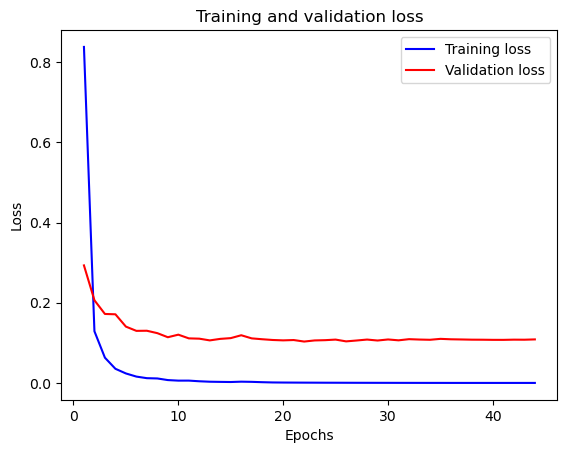

In [13]:
epochs = range(1, len(pretrained_vit_results['train_loss']) + 1)

plt.plot(epochs, pretrained_vit_results['train_loss'], 'b-', label='Training loss')
plt.plot(epochs, pretrained_vit_results['val_loss'], 'r-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

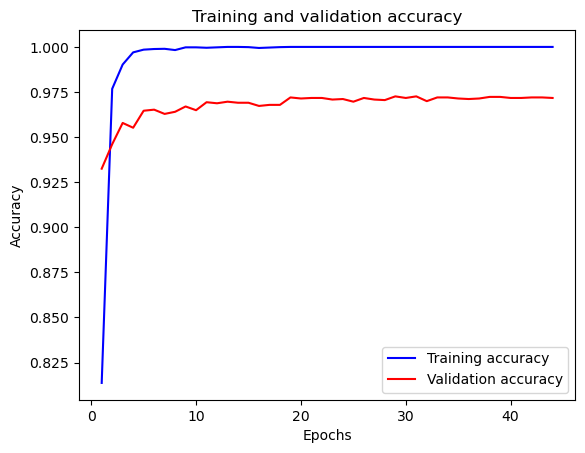

In [14]:
epochs = range(1, len(pretrained_vit_results['train_acc']) + 1)

plt.plot(epochs, pretrained_vit_results['train_acc'], 'b-', label='Training accuracy')
plt.plot(epochs, pretrained_vit_results['val_acc'], 'r-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
loaded_model = torch.load('Results/Models/BestModel.pth')

# Switch the model to evaluation mode
loaded_model.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Тестирање модела</h2>
</div>

In [16]:
set_seeds(33)
test_loss, test_acc = engine.test(model=loaded_model,
                           test_dataloader=test_dataloader_pretrained,
                           loss_fn=loss_fn,
                           device=device)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.1005, Test Accuracy: 0.9735


In [17]:
import pickle

# Save the pretrained_vit_results dictionary to disk
with open('Results/Training results/pretrained_vit_results.pkl', 'wb') as f:
    pickle.dump(pretrained_vit_results, f)

In [18]:
with open('Results/Training results/pretrained_vit_results.pkl', 'rb') as f:
    loaded_pretrained_vit_results = pickle.load(f)